In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import json

In [3]:
# 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
source_url = "https://store.naver.com/sogum/api/businesses?"

# 검색 규칙 파라미터를 추가합니다.
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=중계역+식당"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting

# 반환받은 API 데이터에 json.loads 함수를 사용합니다.
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

# 관련도순 상위 100개의 고기집 리스트 정보를 출력합니다.
print(str(restaurant_list_data)[:100]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '중계역', 'region_type': 'favor', 'r...


In [4]:
restaurant_id_list = []

import urllib


# 100개씩의 API 호출 결과를 10번 가져옵니다.
for start_idx in [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]:
    
    # 네이버 플레이스 API를 호출하기 위한 기본 주소입니다.
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    # 검색 규칙 파라미터를 추가합니다.
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=중계역+맛집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    #json_data = requests.get(url_concat).text
    json_data = requests.get(url_concat).json()
    #restaurant_list_data = json.loads(json_data)
    restaurant_list_data = json_data


    # 크롤링에 필요한 각 리뷰 상세 페이지의 id를 추출합니다.
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))



request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=중계역+맛집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=301&display=400&query=중계역+맛집&sortingOrder=precision


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [5]:
import requests
from bs4 import BeautifulSoup
import re

columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# 리뷰 상세 페이지의 기본 주소입니다.
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파라미터로 추가합니다.
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않습니다.
    if review_area is None:
        continue

    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출합니다.
    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터프레임으로 병합합니다.
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")


Crawl 0 % complete..
Crawl 3 % complete..
Crawl 6 % complete..
Crawl 10 % complete..
Crawl 13 % complete..
Crawl 16 % complete..
Crawl 20 % complete..
Crawl 23 % complete..
Crawl 26 % complete..
Crawl 30 % complete..
Crawl 33 % complete..
Crawl 36 % complete..
Crawl 40 % complete..
Crawl 43 % complete..
Crawl 46 % complete..
Crawl 50 % complete..
Crawl 53 % complete..
Crawl 56 % complete..
Crawl 60 % complete..
Crawl 63 % complete..
Crawl 66 % complete..
Crawl 70 % complete..
Crawl 73 % complete..
Crawl 76 % complete..
Crawl 80 % complete..
Crawl 83 % complete..
Crawl 86 % complete..
Crawl 90 % complete..
Crawl 93 % complete..
Crawl 96 % complete..
Crawl 100 % complete


In [6]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()


(72, 3)


,score,review,y
0,5,맛있게 잘 먹었어요~♡\n식사중에 비가 내려서 더 좋았습니다~,1
1,5,집에만 있기 답답해서\n엄마랑 단둘이 데이트하러\n노원맛집 찾아 마실갔는데\n아주 ...,1
2,4,맛있었어요! ㅎ 주차 할 곳이 없어서 조금 애먹었어요ㅠㅎㅎ 그리고 매뉴가 좀 늦게 ...,1
3,2,예약하고 갔더니 오늘 예약없었다고 하더라구요.\n네이버통해 예약했다니깐 그제서야 이...,0
4,4,맛있었어요\n사람이 많아서인지 \n친절하시다는 느낌은 못받았어요;,1


In [7]:
df.to_csv("review_data.csv", index=False)

df = pd.read_csv("./review_data.csv")

In [8]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    #hangul = re.compile('[\u3131-\u3163\uac00-\ud7a3]+')
    #hangul = re.findall(u"[a-zA-Z0-9]", myStr)
    #hangul = re.findall(u"[\w]", myStr)
    result = hangul.sub('', text)
    return result


In [9]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,5.0,1,맛있게 잘 먹었어요식사중에 비가 내려서 더 좋았습니다
1,5.0,1,집에만 있기 답답해서엄마랑 단둘이 데이트하러노원맛집 찾아 마실갔는데아주 만족스러운 ...
2,4.0,1,맛있었어요 ㅎ 주차 할 곳이 없어서 조금 애먹었어요ㅠㅎㅎ 그리고 매뉴가 좀 늦게 나...
3,2.0,0,예약하고 갔더니 오늘 예약없었다고 하더라구요네이버통해 예약했다니깐 그제서야 이름 얘...
4,4.0,1,맛있었어요사람이 많아서인지 친절하시다는 느낌은 못받았어요


In [10]:
df['ko_text'][0]

'맛있게  잘 먹었어요식사중에 비가 내려서 더 좋았습니다'

In [ ]:
#!pip install JPype1-0.7.5-cp37-cp37m-win32.whl

In [ ]:
#!pip install --upgrade pip & pip3 install -U pip

In [ ]:
#!pip install konlpy

In [11]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출합니다.
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos


In [12]:
# 형태소 추출 동작을 테스트합니다.
result = get_pos(df['ko_text'][0])
print(result)

['맛있게/Adjective', '잘/Verb', '먹었어요/Verb', '식사/Noun', '중/Suffix', '에/Josa', '비/Noun', '가/Josa', '내려서/Verb', '더/Noun', '좋았습니다/Adjective']


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())


In [14]:
X.shape

(72, 713)

In [15]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'맛있게/Adjective': 224, '잘/Verb': 519, '먹었어요/Verb': 249, '식사/Noun': 372, '중/Suffix': 580, '에/Josa': 4..


In [16]:
print(df['ko_text'][0])
print(X[0])

맛있게  잘 먹었어요식사중에 비가 내려서 더 좋았습니다
  (0, 224)	1
  (0, 519)	1
  (0, 249)	1
  (0, 372)	1
  (0, 580)	1
  (0, 428)	1
  (0, 326)	1
  (0, 9)	1
  (0, 103)	1
  (0, 150)	1
  (0, 569)	1


In [17]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)


(50, 713)
(22, 713)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))


accuracy: 0.86
Precision : 0.864
Recall : 1.000
F1 : 0.927


In [19]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[ 0  3]
 [ 0 19]]


AUC : 0.667


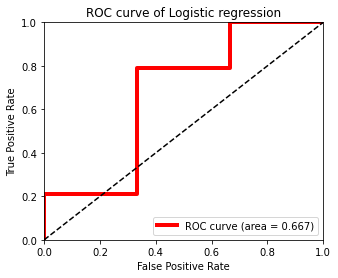

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")


In [30]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력합니다.
df['y'].value_counts()


1    61
0    11
Name: y, dtype: int64

In [44]:
# 1:1 비율로 랜덤 샘플링을 수행합니다.
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()

ValueError: Cannot take a larger sample than population when 'replace=False'

In [45]:
# 랜덤 데이터로 데이터셋을 나눕니다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

NameError: name 'negative_random_idx' is not defined

In [40]:
# 로지스틱 회귀모델을 다시 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 학습한 모델을 테스트 데이터로 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.86
Precision : 0.864
Recall : 1.000
F1 : 0.927


In [41]:
# Confusion matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)


[[ 0  3]
 [ 0 19]]


AUC : 0.667


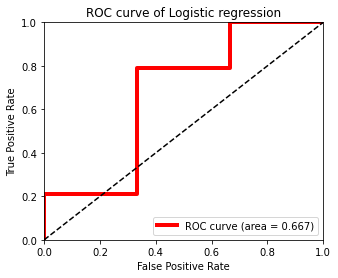

In [42]:
# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

<BarContainer object of 713 artists>

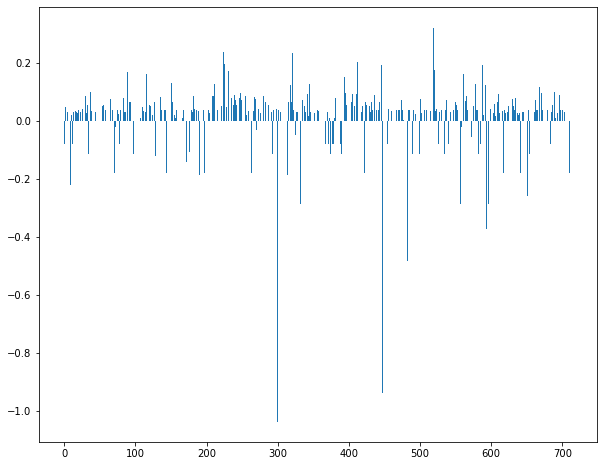

In [43]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [46]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.3234276364326295, 154), (0.31931211728446685, 519), (0.31327715356722186, 233), (0.23480580797864092, 224), (0.23169010456634687, 321)]
[(-0.5079599249046997, 487), (-0.5101934718745713, 486), (-0.6945440960973457, 309), (-0.9367550588736089, 447), (-1.0384671320788204, 300)]


In [47]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)


In [48]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')


{224: '맛있게/Adjective', 519: '잘/Verb', 249: '먹었어요/Verb', 372: '식사/Noun', 580: '중/Suffix', 428: '에/Jos..


In [49]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])


도/Josa 0.3234276364326295
잘/Verb 0.31931211728446685
맛있었어요/Adjective 0.31327715356722186
맛있게/Adjective 0.23480580797864092
분위기/Noun 0.23169010456634687
좀/Noun 0.21831738686824512
양/Noun 0.20120297414299512
맛있고/Adjective 0.19589865729622052
직원/Noun 0.19304848290494153
예약/Noun 0.19289169358109093
사람/Noun 0.1877685683837378
잘/VerbPrefix 0.17254597575975392
맛있어요/Adjective 0.16934974067610065
나/Josa 0.16594971522242596
특히/Adverb 0.1623124523495067
좋고/Adjective 0.161241226138727
먹고/Verb 0.16085912446598025
느낌/Noun 0.15951569603243645
에서/Josa 0.15540604646634282
아주/Noun 0.1508854137415849


In [50]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])


나온/Verb -0.18658417119264617
가/Josa -0.2226177998129986
것/Noun -0.23888971741765003
은/Josa -0.25012779964007326
지점/Noun -0.2556350572876652
서비스/Noun -0.26003807737830364
튀김/Noun -0.26145263574585487
짠/Verb -0.28823896194624604
좁고/Adjective -0.28823896194624604
비해/Verb -0.28823896194624604
다른/Noun -0.28823896194624604
짜고/Verb -0.37316834238529234
였습니다/Verb -0.4283282046536067
같아요/Adjective -0.46592839903948663
음식/Noun -0.48280476772737163
이/Suffix -0.5079599249046997
이/Josa -0.5101934718745713
보통/Noun -0.6945440960973457
예요/Josa -0.9367550588736089
별로/Noun -1.0384671320788204


In [51]:
noun_list = []
adjective_list = []

# 명사, 형용사별로 계수가 높은 상위 10개의 형태소를 추출합니다. 이는 리뷰에 긍정적인 영향을 주는 명사와 형용사를 순위별로 살펴보는 것이 됩니다.
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1]
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [52]:
# 상위 10개의 명사를 출력합니다.
noun_list[:10]

[('분위기/Noun', 0.23169010456634687),
 ('좀/Noun', 0.21831738686824512),
 ('양/Noun', 0.20120297414299512),
 ('직원/Noun', 0.19304848290494153),
 ('예약/Noun', 0.19289169358109093),
 ('사람/Noun', 0.1877685683837378),
 ('느낌/Noun', 0.15951569603243645),
 ('아주/Noun', 0.1508854137415849),
 ('덕분/Noun', 0.12907915828688152),
 ('예정/Noun', 0.12768413838438986)]

In [53]:
# 상위 10개의 형용사를 출력합니다.
adjective_list[:10]

[('맛있었어요/Adjective', 0.31327715356722186),
 ('맛있게/Adjective', 0.23480580797864092),
 ('맛있고/Adjective', 0.19589865729622052),
 ('맛있어요/Adjective', 0.16934974067610065),
 ('좋고/Adjective', 0.161241226138727),
 ('많아서/Adjective', 0.1275729751533693),
 ('좋았습니다/Adjective', 0.12227052943344634),
 ('좋았어요/Adjective', 0.09740129862676845),
 ('친절하셨어요/Adjective', 0.09467934713670459),
 ('아쉽네요/Adjective', 0.09302228347760863)]